# Anomaly Detection - Algorithms in Machine Learning

**Authors: Ziqing WU, Shuang HOU**

Table of contents:
1. [Context](#sec1)
2. [Problem formulation](#sec2)
    1. [First data investigation](#sec2-1)
    2. [Problem description](#sec2-2)
    3. [Limitation from data aspect](#sec2-3)
3. [Methods](#sec3)
4. [Results](#sec4)
    1. [Feature selection](#sec4-1)
    2. [Anomaly detection](#sec4-2)
    3. [Anomaly window display](#sec4-3)
5. [Conclusion](#sec5)
    1. [Anomalies detected](#sec5-1)
    2. [Open questions](#sec5-2)

## 1. <a id="sec1"></a>Context

Aircraft systems are recording values of parameters such as speed, temperature, pressure, electrical current values... 

The measures are divided into sections of window. Each window contains 100 measure points. The window is the smallest unit of sections. Beyond this, each cycle contains several windows and each day contains several cycles. 

The dataset contains 162702 lines and 12 colomns with 11 parameters and 1 label "day_cycle_window".

With this dataset, an aircraft system expert is searching for the help of data scientist to "build an algorithm to detect windows that are abnormal".

## 2. <a id="sec2"></a>Problem formulation

Data scientists need to have a global understanding of the data to be able to provide the appropriate formulation of the problem. The first question that we ask is how to summerize information on the window scale based on the fact that we have 100 data points for each window. The second question is that what kind of anomalies that we are facing and how to define anomalies. The last step is to discuss with the expert, in order to show them what information can we get from the provided data and what supplementary information that we need to identify the "anomalies".


### A. <a id="sec2-1"></a>First data investigation

#### A.1 Count windows and data points per window

Firstly, some general information needs to be provided.

In [1]:
# Necessary library importation for this section
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
dataset = pd.read_csv("dataset.csv")
index_window, num_perwindow = np.unique(dataset["day_cycle_window"], return_counts = True)
print(f'The dataset contains {len(index_window)} windows.')
print(f'The number of data points from each window varies from {num_perwindow.min()} to {num_perwindow.max()}.')

The dataset contains 1637 windows.
The number of data points from each window varies from 2 to 100.


<div class="alert alert-block alert-warning">
<b>Attention:</b> For some windows, the measure points were too little to provide the statistical information for the window.
</div>

We can then deduce the **first type of anomaly**: the problem of measurements, meaning that for a specific window, the measure points can not reach 100, showing a discontinuity of measurements in this window. This can be a discussion point with aircraft system expert, asking for the confirmation of potential measuring problems.

In [3]:
num_perwindow_sorted = np.sort(num_perwindow)
l = len(num_perwindow_sorted[num_perwindow_sorted!=100])
print(f'The number of windows for which the number of data points is not 100 is : {l}.')
index_anomaly1 = np.argsort(num_perwindow)[:l]
window_anomaly1 = index_window[index_anomaly1]
print(f'The corresponding windows are {window_anomaly1}.')

The number of windows for which the number of data points is not 100 is : 15.
The corresponding windows are ['3_3_181' '2_1_181' '3_1_181' '1_2_181' '4_2_181' '3_2_52' '1_5_94'
 '4_3_65' '2_3_145' '1_4_17' '1_3_6' '2_2_76' '1_1_68' '4_4_160' '4_1_49'].


Before confirming this point, we will do an assumption that all the windows need to have 100 times of measurements to be considered to be normal. So for the following sections, only "normal windows" with 100 points will be conserved.

In [4]:
# filter the dataset to save only the windows with 100 data points
dataset_no1anomaly = dataset[~dataset.day_cycle_window.isin(window_anomaly1)]

#### A.2 Check the information of a random window

In order to detect the anomaly on a window basis, one needs to extract the statistical parameters from each window for each parameter. Which parameters to be chosen is the core problem of this step. In order to answer this question, we want to explore the data distribution of each window for each variable.

The window selected is ['4_4_148'].


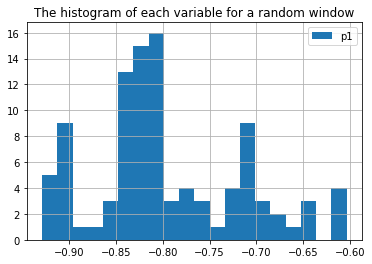

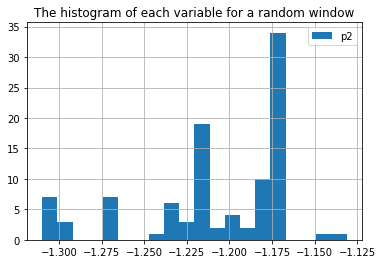

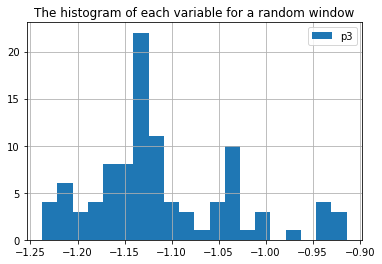

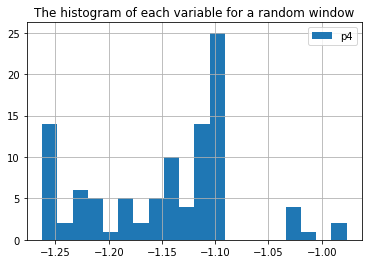

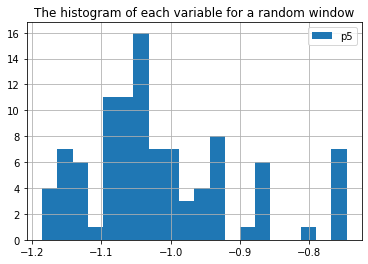

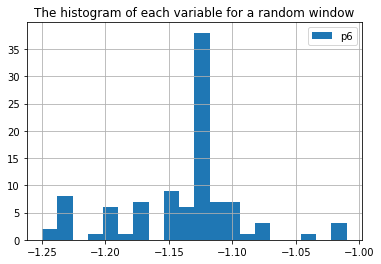

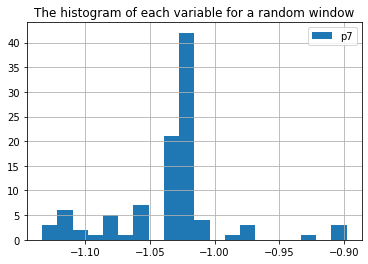

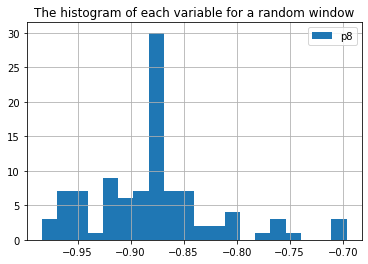

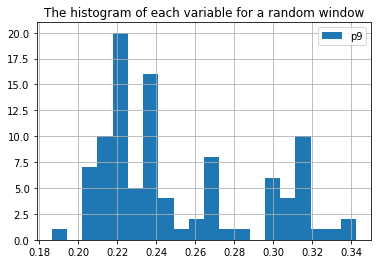

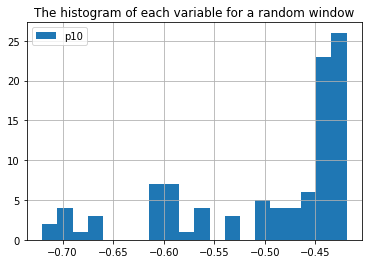

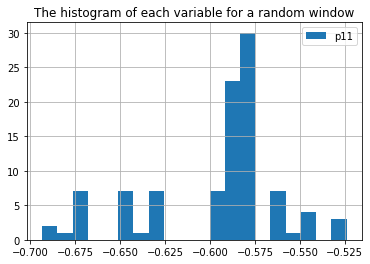

In [5]:
# select a window randomly and then check the distribution of each variable
window_no1anomaly = np.setdiff1d(index_window, window_anomaly1)
random_window = np.random.choice(window_no1anomaly, size = 1)
print(f'The window selected is {random_window}.')
for i in np.arange(1,dataset.shape[1]):
    plt.figure()
    dataset[dataset.day_cycle_window == random_window[0]].iloc[:,i].hist(bins = 20, label = dataset.columns[i])
    plt.title("The histogram of each variable for a random window")
    plt.legend()

In the above section, we have selected randomly a window to see the distribution of each variables. In these histograms, the distribution is not actually Gaussian for many variables. In fact, we can see several peaks on the graph, showing a bimodal or multimodal distribution. We will then compare the distribution of different windows for the same variable.

The variable selected is ['p3'].


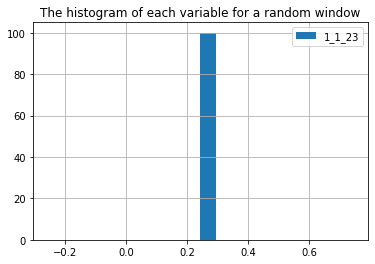

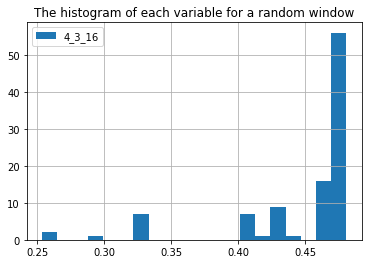

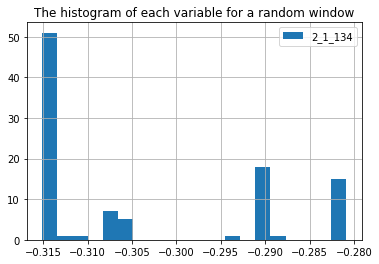

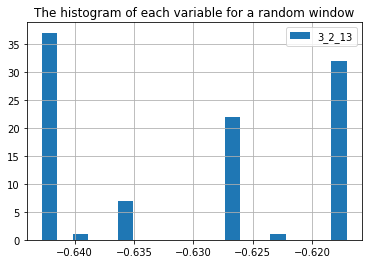

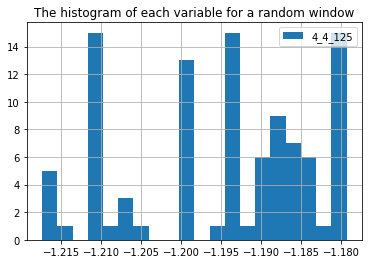

In [6]:
# select a variable randomly and then check the distribution for different windows 
random_variable = np.random.choice(dataset.columns, size = 1)
print(f'The variable selected is {random_variable}.')
random_windows = np.random.choice(window_no1anomaly, size = 5)
for i in np.arange(5):
    plt.figure()
    dataset[dataset.day_cycle_window == random_windows[i]].loc[:,random_variable[0]].hist(bins = 20, label = random_windows[i])
    plt.title("The histogram of each variable for a random window")
    plt.legend()

We can see that even for the same variable, we do have different distributions for different windows. Again, few of them are following the Gaussian distribution. Thus, it is not appropriate to use the mean and the variance to summerize the information on each window. 

<div class="alert alert-block alert-warning">
<b>Proposition:</b> We use the median and the median absolute deviation (MAD) to obtain robust descriptors for each variable and each window.
</div>

Here we recall the definition of the median absolute deviation (MAD):
$$MAD = median(|x-median(x)|)$$

#### A.3 Global data investigation

Before getting to the process of anomaly detection, we want to make sure that the data is clean enough, meaning there is no null value.

In [7]:
print(f'Is there any missed value in the dataframe? {dataset_no1anomaly.isnull().values.any()}!')

Is there any missed value in the dataframe? False!


In [8]:
dataset_no1anomaly.describe()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
count,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000
mean,0.000396,-0.000680,-0.002286,-0.000366,-0.000363,0.000805,0.000823,0.000291,0.002817,-0.001299,-0.002914
std,0.999141,0.998478,0.995442,0.998792,0.998532,0.998860,0.999383,0.999187,0.992008,0.987465,0.994999
min,-3.211980,-3.395387,-3.325651,-3.378450,-3.281286,-4.200181,-3.898025,-3.524957,-13.704556,-10.621700,-3.183571
25%,-0.678808,-0.482556,-0.629276,-0.491163,-0.611638,-0.559023,-0.605228,-0.737095,-0.590086,-0.499300,-0.658530
50%,0.042896,0.179877,0.040733,0.147397,0.117040,0.154443,0.186879,-0.011674,-0.032984,-0.257635,-0.016261
75%,0.743797,0.655579,0.656998,0.636887,0.711965,0.684938,0.719222,0.802395,0.508989,0.357578,0.633398
max,5.013899,6.260782,8.652950,8.359670,6.424227,5.638259,3.735957,4.667058,8.203706,5.597387,9.204384


A brief check on the data tells us that the data is quite centered (mean closed to 0 for each variable), and with a standard deviation closed to 1. Thus no more preprocess step is to be conducted.

We are also interested in the variable correlation for the dataset. If there is a strong correlation among the different variables, we may need to conduct the feature selection to eliminate the correlation and get a better result while doing anomaly detection.

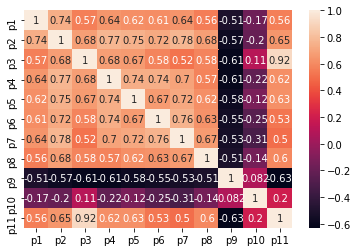

In [9]:
sns.heatmap(dataset_no1anomaly.corr(method = 'pearson'), annot = True)

In [10]:
corr = dataset_no1anomaly.corr(method = 'pearson')
print(f'The number of highly correlated pairs is {(corr[np.abs(corr)>0.5].count().sum()-11)/2}.')

The number of highly correlated pairs is 44.0.


With the Pearson correlation coefficients, we got a heat map. We can see that many coefficients are higher than 0.5, showing a high correlation between the two indicated variables. Thus, it is necessary to conduct the feature selection in order to reduce the redundent information. The precise method of feature selection will be shown in the section 3.A.

### B. <a id="sec2-2"></a>Problem description
The problem can be divided into some subproblems:
+ Summerizing information for each window
+ Proposing methodologies to detect anomalies
+ Fine-tuning and expert intervention for threshold setting of anomalies

As shown in the previous section, as the distribution of variables in each window is not always normal, we use median and MAD to describe the center and dispersion of the data in each window. With median, we can describe if some windows have overall deviation from others. With MAD, we can describe if the dispersion of some window is too large which may induced by the measurement problems. Two types of anomalies can be observed here.

With median and MAD dataset, we can propose some machine learning methodologies for multivariante case of anomaly detection.

Then the preliminary result can be presented to the experts in order to have a feedback and set the thresholds for anomalies.

### C. <a id="sec2-3"></a>Limitation from the data aspect

Without extra information, we do not have sufficient intuition to detect the abnormal values, meaning that we don't have a clear definition of anomaly. If it can be provided by the expert, the detection can be more precise and closed to the reality. 

We can only use the unsupervised classification method here, which is not optimized in the point of view of data scientists. If we can have some labels for the anomaly before getting to the training step, the result is expected to be better using supervised or semi-supervised classification methods. 

The size of datasets is also an important factor for the detection of anomaly. Here we do have a quite large dataset with ~160 000 lines, but the aggregation on the window level shrinks the dataset, which can be one of the limits of this detection.

Also, the datasets and the anomalies are changing constantly, meaning that one trained model can hardly be used for the evolving data. The update of detection model is necessary to adapt to the changement.

## 3. <a id="sec3"></a>Methods
### A. Dimensionality reduction
In the section 2.A.3, the correlation analysis has proved the necessity to conduct a dimensionality reduction. The common methods for this are feature selection and principle component analysis (PCA). 

#### A.1 Principle Component Analysis

PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. Some components can be selected to explain the total variance of the dataset. This method is not only used to reduce the dimensionality of dataset in order to reduce the correlation among variables, it can also help to provide a better graphic interpretation. 

#### A.2 Feature Selection 

Several feature selection methods are commonly used, such as [variance threshold](https://scikit-learn.org/stable/modules/feature_selection.html#removing-features-with-low-variance), [some methods for univariate feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection), [recursive feature elimination](https://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination) and so on. Most of them request the data label to be able to conduct feature selection, but it is not the case for variance thresholds. 

The feature selection method has its own advantage of conserving most explainability. However, the information may be lost during this transformation. 

For the reason that we do not have labels in our dataset, we can only use the variance thresholds to select the features.

A comparaison of the variance threshold method and PCA will be done in the [Section 4. Results](#sec4) to select a better option for the dimensionality reduction.

### B. Anomaly detection method
Several anomaly detection methods are presented here with their own advantages and disadvantages. We will mainly use three methods that are Isolation Forest, One Class SVM and Local Outlier Factor.

#### B.1 Isolation Forest
In Isolation Forest, anomalies are defined as "more likely to be separated", which can be understood as points that are sparsely distributed and far away from high-density population. In the feature space, sparsely distributed regions indicate that the probability of events occurring in this region is very low, so the data falling in these regions can be considered abnormal.

Isolation Forest is an unsupervised anomaly detection method suitable for continuous numerical data, that is, it does not require labeled samples for training. In Isolation Forest, the dataset is randomly divided recursively until all sample points are isolated. Under this random segmentation strategy, abnormal points usually have shorter paths.

Most of the existing anomaly detection methods expect more data, but in Isolation Forest, small datasets can often achieve better results. A large number of samples will reduce the ability of Isolation Forest to isolate abnormal points, because normal samples will interfere with the isolation process and reduce the ability to isolate anomalies.

#### B.2 Local Outlier Factor
Local Outlier Factor (LOF) is a classic density-based algorithm for anomaly detection. The main idea is the characterization of the density of data points. It calculates a score to characterize the anomaly degree of a sample. This value represents the ratio between the average distance of the k nearest neighbors around the actual sample point and the local reachability density of the actual sample point. The larger the ratio is than 1, the smaller the density of the actual point is compared to the density of its neighbors, the more likely this point is an anomaly.

Compared with other anomaly detection methods based on statistical methods or clustering algorithms, the density-based LOF algorithm is simpler and more intuitive. It does not restrict too much about data distribution and can also quantify the outlierness of each data point. One disadvantage of the LOF algorithm is that since it needs to calculate the distance between all pairs of data points, it will increase the time complexity of the entire algorithm.

#### B.3 One Class SVM
The main idea of the One Class SVM algorithm is to find a hyperplane to circle the normal samples in the dataset. The prediction process is to use this hyperplane to make decisions. The samples in the circle are considered as normal samples, and the samples outside the circle are considered as outliers.

More generally, One CLass SVM is not only used for outlier detection, it shows a better performance in novelty detection. In the novelty detection, its training set should not be mixed with abnormal points, because the model may match these abnormal points. But when the dataset has a very high dimension, or there is no assumption about the distribution of points in dataset, One Class SVM can also be used as a good method for outlier detection.


These three algorithms can be used for our dataset, but the results for each algorithm may be different, depending on the methodology.

## 4. <a id="sec4"></a>Results
We begin with the aggregation of information, using median and MAD, per window. 

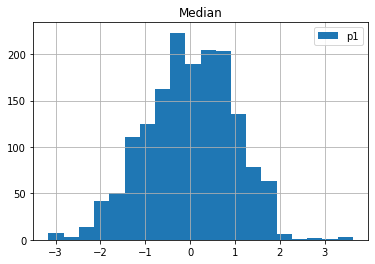

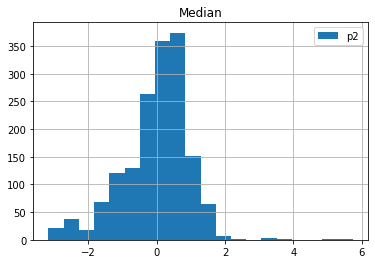

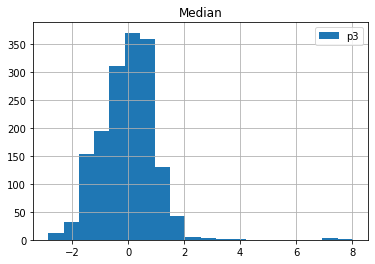

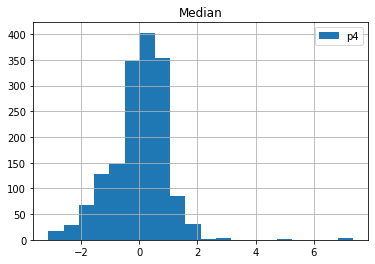

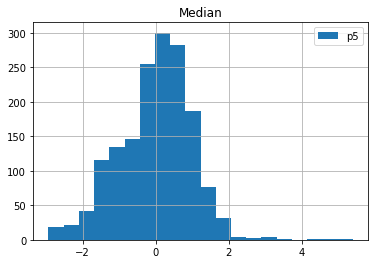

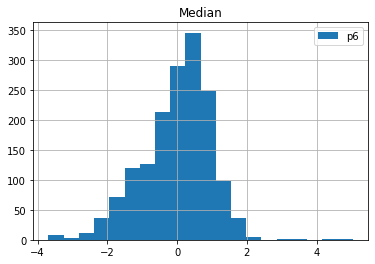

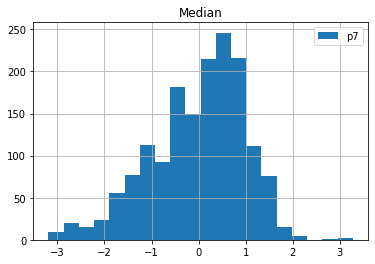

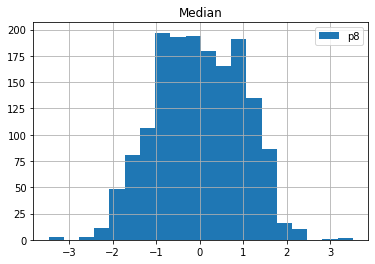

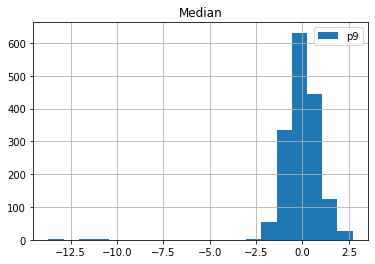

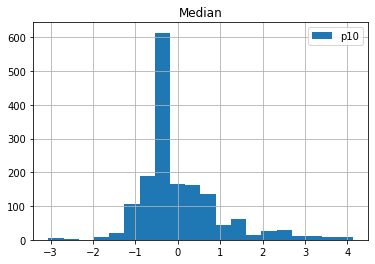

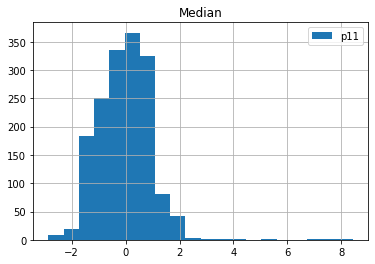

In [11]:
median_per_window = dataset_no1anomaly.groupby(["day_cycle_window"]).median()
for i in range(median_per_window.columns.shape[0]):
    plt.figure()
    median_per_window.iloc[:, i].hist(bins = 20, label = median_per_window.columns[i])
    plt.legend()
    plt.title("Median")

From the histogram of median distribution of each variable, it can be found that the median conforms to a standard normal distribution in the "window" level, except for a few abnormal points.

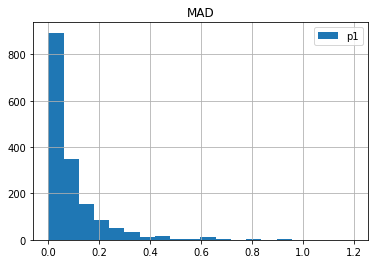

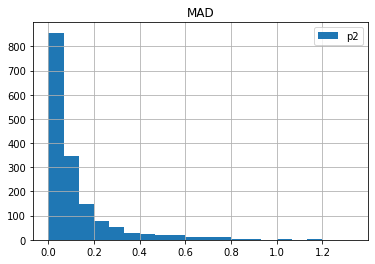

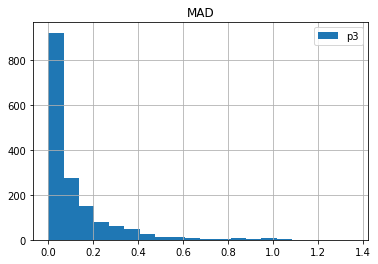

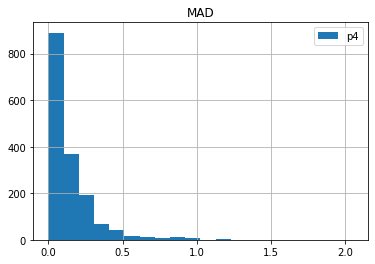

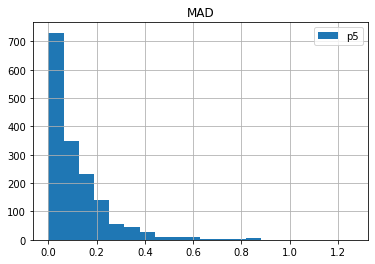

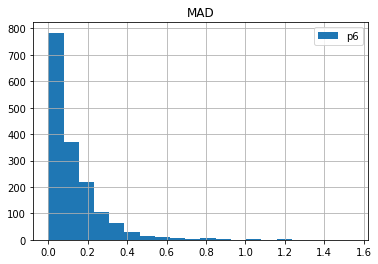

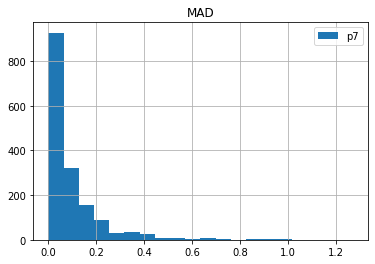

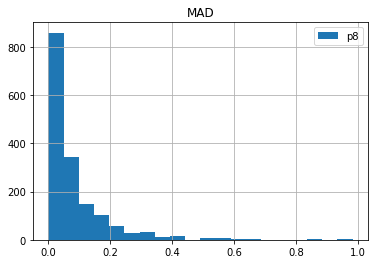

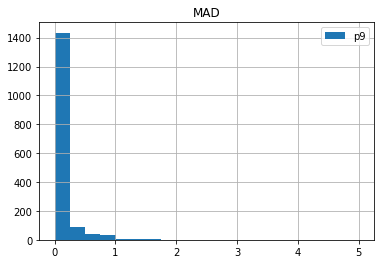

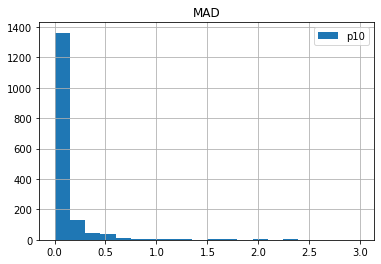

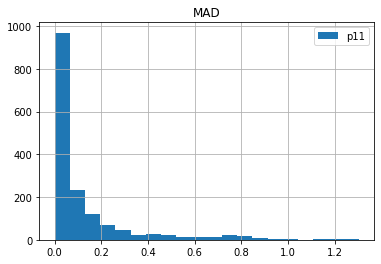

In [12]:
mad_per_window = dataset_no1anomaly.groupby(["day_cycle_window"]).mad()
for i in range(mad_per_window.columns.shape[0]):
    plt.figure()
    mad_per_window.iloc[:, i].hist(bins = 20, label = mad_per_window.columns[i])
    plt.legend()
    plt.title("MAD")

From the histogram of the MAD distribution of each variable, the values of MAD are mostly around 0, which show that the dataset has a low dispersion and thus data is concentrated.

### A.<a id="sec4-1"></a> Feature selection

We would like to test PCA and variance threshold method here in order to choose an appropriate one for the feature selection.

In [13]:
# PCA
from sklearn.decomposition import PCA

# PCA dimensionality reduction on 'median_per_window'
pca_median = PCA(n_components = 2)
pca_median.fit(median_per_window)
X_median = pca_median.transform(median_per_window)
print(f'PCA ratio for median = {sum(pca_median.explained_variance_ratio_)}')

# PCA dimensionality reduction on 'mad_per_window'
pca_mad = PCA(n_components = 2)
pca_mad.fit(mad_per_window)
X_mad = pca_mad.transform(mad_per_window)
print(f'PCA ratio for MAD = {sum(pca_mad.explained_variance_ratio_)}')

PCA ratio for median = 0.7503899955567211
PCA ratio for MAD = 0.8047318485270238


For each window, the PCA is used on median and MAD respectively to conduct the dimensionality reduction, we choose to retain 2 principal components. The PCA ratio of the median is about 75%, and that of MAD is about 80.5%. These two scores indicate that both of them can well characterize the dataset.

In [14]:
# Variance Threshold
from sklearn.feature_selection import VarianceThreshold

#  Variance Threshold on 'median_per_window'
sel_median = VarianceThreshold(threshold = 0.9815)
X2_median = sel_median.fit_transform(median_per_window)
print(f'Shape of dataset after VarianceThreshold on median : {X2_median.shape}')
print(f'VarianceThreshold ratio for median of each variable : {sel_median.variances_}')

print('-'*100)

#  Variance Threshold on 'mad_per_window'
sel_mad = VarianceThreshold(threshold = 0.05)
X2_mad = sel_mad.fit_transform(mad_per_window)
print(f'Shape of dataset after Variance threshold on mad : {X2_mad.shape}')
print(f'VarianceThreshold ratio for mad of each variable : {sel_mad.variances_}')

print('-'*100)

ratio_median = np.sort(sel_median.variances_)[-2:].sum() / (sel_median.variances_).sum()
ratio_mad = np.sort(sel_mad.variances_)[-2:].sum() / (sel_mad.variances_).sum()
print(f'Variance threshold ratio for median : {ratio_median}')
print(f'Variance threshold ratio for mad : {ratio_mad}')

Shape of dataset after VarianceThreshold on median : (1622, 2)
VarianceThreshold ratio for median of each variable : [0.975097   0.9569541  0.96434354 0.96497017 0.97732917 0.97421788
 0.98106643 0.98511475 0.98162559 0.90958629 0.93441083]
----------------------------------------------------------------------------------------------------
Shape of dataset after Variance threshold on mad : (1622, 2)
VarianceThreshold ratio for mad of each variable : [0.01465821 0.02693102 0.02545982 0.03202463 0.01810997 0.02246787
 0.01673908 0.01204338 0.07576159 0.05808603 0.04358074]
----------------------------------------------------------------------------------------------------
Variance threshold ratio for median : 0.1854590337586688
Variance threshold ratio for mad : 0.3869968099046857


In the same way as PCA, for each window, we performed feature selection for median and MAD respectively, and adjusted the value of variance threshold so that the two main features were finally retained. The variance threshold ratio of median is about 18.5%, and the variance threshold ratio of MAD is about 38.7%.

Comparing the result of PCA and VarianceThreshold, the score of PCA is much better than that of VarianceThreshold, that is, the features selected by PCA are more representative of the characteristics of the entire dataset. Therefore, we choose **PCA** for feature selection.

### B. <a id="sec4-2"></a>Anomaly Detection
After conducting feature selection, we will detect anomalies on the transformed data. Here a visualisation function is used to provide a better understanding of the results. As we have reduced the dimension to 2, we can thus plot the data points on a plane in order to provide a clear view of anomaly distribution. Here the function used in the course has been reused to display the anomaly score.

In [15]:
def plotAnomalyScore2D(df, clf_name, clf):
    """
        df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        clf_name: String value - name of the outlier detection model
        clf: Scikit Learn model instance - the trained outlier detection model
    """
    if clf_name == 'LOF':
        score = clf.negative_outlier_factor_
    else:
        score = clf.decision_function(df[['X1','X2']])
    
    plt.figure()
    sc = plt.scatter(x=df['X1'],y=df['X2'], c=-score, cmap='Reds')
    plt.colorbar(sc, label='anomaly score')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(clf_name)

Following we will use three different algorithms (IsolationForest, LocalOutlierFactor, OneClassSVM) to conduct outlier detection, for the median and MAD respectively, on the dataset after feature selection on all windows.

#### B.1 Median Anomaly Detection

Prediction scores for median = [-0.03715362  0.03010626  0.04756461 ...  0.07238945  0.06528496
  0.03591831]


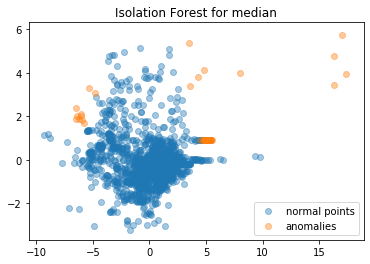

In [16]:
# Implementation of Isolation Forest on median_per_window
from sklearn.ensemble import IsolationForest

iso_median = IsolationForest(n_estimators=100, max_samples=8, contamination=0.15)
iso_median_pred = iso_median.fit_predict(X_median)

scores_pred_median = iso_median.decision_function(X_median)
print(f'Prediction scores for median = {scores_pred_median}')


# Manually define the proportion of outliers
percent = 0.03
i = np.int(percent * X_median.shape[0])

scores_pred_median[scores_pred_median < max(sorted(scores_pred_median)[:i])]
index_outlier_median = np.argsort(scores_pred_median)[:i]
index_anomaly2_IF = index_outlier_median

index_all_median = np.arange(len((X_median)))
index_without_outlier_median = np.setdiff1d(index_all_median, index_outlier_median)


plt.figure()
plt.scatter(X_median[index_without_outlier_median][:,0], X_median[index_without_outlier_median][:,1], alpha=.4, label = 'normal points')
plt.scatter(X_median[index_outlier_median][:,0], X_median[index_outlier_median][:,1], alpha=.4, label = 'anomalies')
plt.title("Isolation Forest for median")
plt.legend()

Prediction scores for median = [-2.85724639 -2.25710295 -6.37426367 ... -0.98916584 -0.97782771
 -0.99773871]


Text(0.5, 1.0, 'Local Outlier Factor for median')

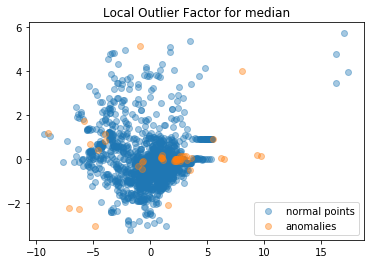

In [17]:
# Implementation of LOF on median_per_window
from sklearn.neighbors import LocalOutlierFactor

lof_median = LocalOutlierFactor(n_neighbors=5, contamination=0.15, novelty=False)
lof_pred_median = lof_median.fit_predict(X_median)

scores_pred_median = lof_median.negative_outlier_factor_
print(f'Prediction scores for median = {scores_pred_median}')


# Manually define the proportion of outliers
percent = 0.03
i = np.int(percent * X_median.shape[0])

scores_pred_median[scores_pred_median < max(sorted(scores_pred_median)[:i])]
index_outlier_median = np.argsort(scores_pred_median)[:i]
index_anomaly2_LOF = index_outlier_median

index_all_median = np.arange(len((X_median)))
index_without_outlier_median = np.setdiff1d(index_all_median, index_outlier_median)


plt.figure()
plt.scatter(X_median[index_without_outlier_median][:,0], X_median[index_without_outlier_median][:,1], alpha=.4, label = 'normal points')
plt.scatter(X_median[index_outlier_median][:,0], X_median[index_outlier_median][:,1], alpha=.4, label = 'anomalies')
plt.legend()
plt.title("Local Outlier Factor for median")

Prediction scores for median = [-19.49379716   0.60823205   0.83729457 ...   0.09505076   0.16816369
   0.60057139]


Text(0.5, 1.0, 'One Class SVM for median')

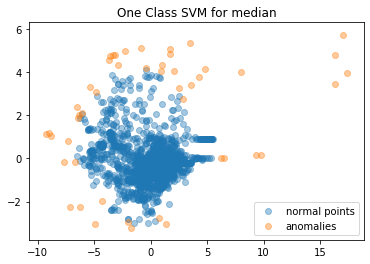

In [18]:
# Implementation of One Class SVM on median_per_window
from sklearn.svm import OneClassSVM

ocsvm_median = OneClassSVM(nu=0.15, kernel="rbf", gamma=0.3) # nu corresponds to contamination
ocsvm_pred_median = ocsvm_median.fit_predict(X_median)

scores_pred_median = ocsvm_median.decision_function(X_median)
print(f'Prediction scores for median = {scores_pred_median}')


# Manually define the proportion of outliers
percent = 0.03
i = np.int(percent * X_median.shape[0])

scores_pred_median[scores_pred_median < max(sorted(scores_pred_median)[:i])]
index_outlier_median = np.argsort(scores_pred_median)[:i]
index_anomaly2_OCSVM = index_outlier_median

index_all_median = np.arange(len((X_median)))
index_without_outlier_median = np.setdiff1d(index_all_median, index_outlier_median)


plt.figure()
plt.scatter(X_median[index_without_outlier_median][:,0], X_median[index_without_outlier_median][:,1], alpha=.4, label = 'normal points')
plt.scatter(X_median[index_outlier_median][:,0], X_median[index_outlier_median][:,1], alpha=.4, label = 'anomalies')
plt.legend()
plt.title("One Class SVM for median")

With assumption that 3% of our data points are anomalies, we can compare the performance of algorithms and distribution of anomalies for Isolation Forest, Local Outlier Factor and One Class SVM. Isolation Forest and One Class SVM can efficiently detect the data points that are relatively far from the population. The anomalies obtained by One Class SVM are evenly distributed around the center. For Local Outlier Factor, the algorithm does not define a clear external border but also consider some points in the middle with lower density as anomalies. 

It is quite hard to judge one specific algorithm is appropriate for the anomaly detection in this case. We need to have the intervention of experts to select a best method.

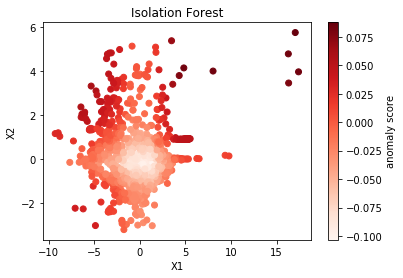

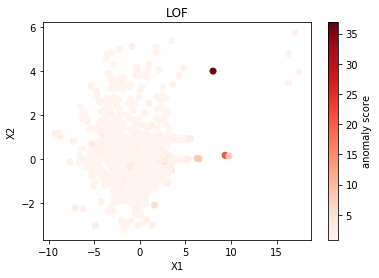

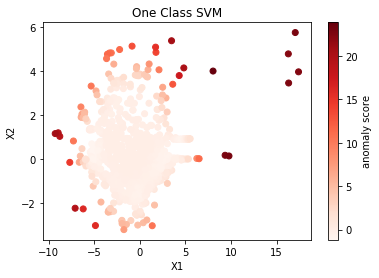

In [19]:
# Anomaly score visualization
# transforme ndarray to dataframe
X_median_df = pd.DataFrame(X_median)
X_median_df.columns = ['X1', 'X2']

# plot anomaly for median
clf_name = 'Isolation Forest'
clf = iso_median
plotAnomalyScore2D(X_median_df, clf_name, clf)

clf_name = 'LOF'
clf = lof_median
plotAnomalyScore2D(X_median_df, clf_name, clf)

clf_name = 'One Class SVM'
clf = ocsvm_median
plotAnomalyScore2D(X_median_df, clf_name, clf)

Here, the anomaly score is displayed for reference. The darker the color is, the higher anomaly score is for the corresponding point.

#### B.2 MAD Anomaly Detection

Prediction scores for MAD = [-0.06975842 -0.01538275  0.06405944 ...  0.11519147  0.01947211
  0.1183205 ]


Text(0.5, 1.0, 'Isolation Forest for MAD')

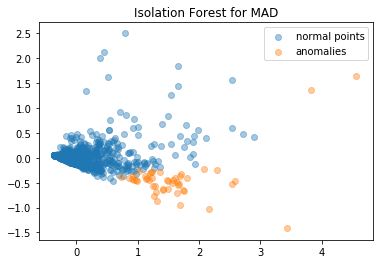

In [20]:
# Implementation of Isolation Forest on mad_per_window
from sklearn.ensemble import IsolationForest

iso_mad = IsolationForest(n_estimators=100, max_samples=8, contamination=0.15)
iso_mad_pred = iso_mad.fit_predict(X_mad)

scores_pred_mad = iso_mad.decision_function(X_mad)
print(f'Prediction scores for MAD = {scores_pred_mad}')


# Manually define the proportion of outliers
percent = 0.03
i = np.int(percent * X_mad.shape[0])

scores_pred_mad[scores_pred_mad < max(sorted(scores_pred_mad)[:i])]
index_outlier_mad = np.argsort(scores_pred_mad)[:i]
index_anomaly3_IF = index_outlier_mad 

index_all_mad = np.arange(len((X_mad)))
index_without_outlier_mad = np.setdiff1d(index_all_mad, index_outlier_mad)


plt.figure()
plt.scatter(X_mad[index_without_outlier_mad][:,0], X_mad[index_without_outlier_mad][:,1], alpha=.4, label = 'normal points')
plt.scatter(X_mad[index_outlier_mad][:,0], X_mad[index_outlier_mad][:,1], alpha=.4, label = 'anomalies')
plt.legend()
plt.title("Isolation Forest for MAD")

Prediction scores for MAD = [-1.04418145 -1.13816465 -1.08230121 ... -1.03018982 -0.97625414
 -1.06864655]


Text(0.5, 1.0, 'Local Outlier Factor for MAD')

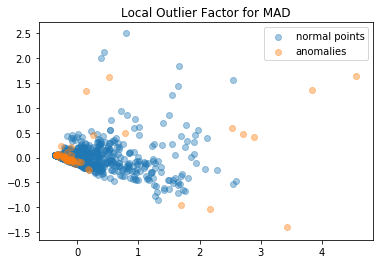

In [21]:
# Implementation of LOF on mad_per_window
from sklearn.neighbors import LocalOutlierFactor

lof_mad = LocalOutlierFactor(n_neighbors=5, contamination=0.15, novelty=False)
lof_pred_mad = lof_mad.fit_predict(X_mad)

scores_pred_mad = lof_mad.negative_outlier_factor_
print(f'Prediction scores for MAD = {scores_pred_mad}')


# Manually define the proportion of outliers
percent = 0.03
i = np.int(percent * X_mad.shape[0])

scores_pred_mad[scores_pred_mad < max(sorted(scores_pred_mad)[:i])]
index_outlier_mad = np.argsort(scores_pred_mad)[:i]
index_anomaly3_LOF = index_outlier_mad 

index_all_mad = np.arange(len((X_mad)))
index_without_outlier_mad = np.setdiff1d(index_all_mad, index_outlier_mad)


plt.figure()
plt.scatter(X_mad[index_without_outlier_mad][:,0], X_mad[index_without_outlier_mad][:,1], alpha=.4, label = 'normal points')
plt.scatter(X_mad[index_outlier_mad][:,0], X_mad[index_outlier_mad][:,1], alpha=.4, label = 'anomalies')
plt.legend()
plt.title("Local Outlier Factor for MAD")

Prediction scores for MAD = [-24.05160035   9.23174922   7.9170254  ...   2.81920818   2.10851753
   3.42472135]


Text(0.5, 1.0, 'One Class SVM for MAD')

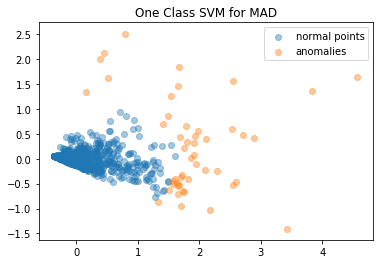

In [22]:
# Implementation of One Class SVM on mad_per_window
from sklearn.svm import OneClassSVM

ocsvm_mad = OneClassSVM(nu=0.15, kernel="rbf", gamma=0.3) # nu corresponds to contamination
ocsvm_pred_mad = ocsvm_mad.fit_predict(X_mad)

scores_pred_mad = ocsvm_mad.decision_function(X_mad)
print(f'Prediction scores for MAD = {scores_pred_mad}')


# Manually define the proportion of outliers
percent = 0.03
i = np.int(percent * X_mad.shape[0])

scores_pred_mad[scores_pred_mad < max(sorted(scores_pred_mad)[:i])]
index_outlier_mad = np.argsort(scores_pred_mad)[:i]
index_anomaly3_OCSVM = index_outlier_mad 

index_all_mad = np.arange(len((X_mad)))
index_without_outlier_mad = np.setdiff1d(index_all_mad, index_outlier_mad)


plt.figure()
plt.scatter(X_mad[index_without_outlier_mad][:,0], X_mad[index_without_outlier_mad][:,1], alpha=.4, label = 'normal points')
plt.scatter(X_mad[index_outlier_mad][:,0], X_mad[index_outlier_mad][:,1], alpha=.4, label = 'anomalies')
plt.legend()
plt.title("One Class SVM for MAD")

Similar to previous section, we have applied three algorithms on the MAD dataset assuming that there are 3% of anomalies. As we can see from the graphs, Isolation Forest and One Class SVM detect the extreme outliers for the MAD value. However, Local Outlier Factor consider also some internal points as anomalies. Again, some help from experts will be useful to clearly define the anomaly.

Intuitively, if we observe the graphs, we may say that One Class SVM can better capture the external points that are far from the population, than other two algorithms.

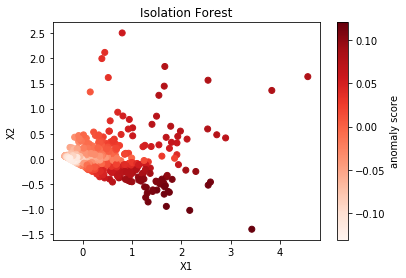

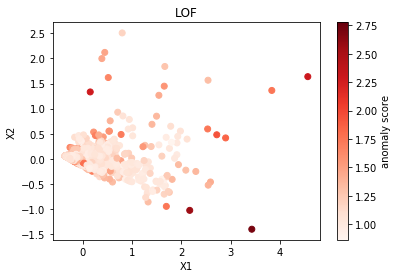

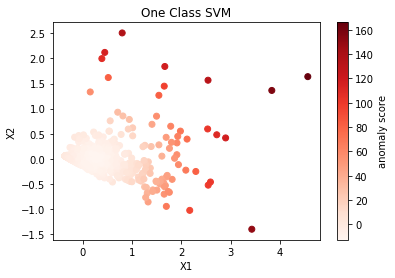

In [23]:
# Anomaly score visualization
# transforme ndarray to dataframe
X_mad_df = pd.DataFrame(X_mad)
X_mad_df.columns = ['X1', 'X2']

# plot anomaly for MAD
clf_name = 'Isolation Forest'
clf = iso_mad
plotAnomalyScore2D(X_mad_df, clf_name, clf)

clf_name = 'LOF'
clf = lof_mad
plotAnomalyScore2D(X_mad_df, clf_name, clf)

clf_name = 'One Class SVM'
clf = ocsvm_mad
plotAnomalyScore2D(X_mad_df, clf_name, clf)

Again, the anomaly score is displayed for reference. 

### C. <a id="sec4-3"></a>Anomaly window display

With all the analysis above, we can then identify which windows are considered as anomalies. As explained before, the anomalies can be divided into 3 categories:
+ Anomaly I: The windows for which the data points are not 100.
+ Anomaly II: The windows for which the center (median) of the data is far from the population.
+ Anomaly III: The windows for which the dispersion is too strange comparing to the population, which can be quantified by the MAD characteristics. 

For the type II and type III anomaly, as we have used three algorithms to conduct the outlier detection, we have identified different windows for each algorithm.

In the following section, an anomaly matrix will be provided to show for each window, which type of anomalies are detected.

In [24]:
all_median_per_window = dataset.groupby(["day_cycle_window"]).median()

In [25]:
dcw_anmly1 = all_median_per_window.iloc[index_anomaly1].index
dcw_anmly2_IF = median_per_window.iloc[index_anomaly2_IF].index
dcw_anmly2_LOF = median_per_window.iloc[index_anomaly2_LOF].index
dcw_anmly2_OCSVM = median_per_window.iloc[index_anomaly2_OCSVM].index
dcw_anmly3_IF = mad_per_window.iloc[index_anomaly3_IF].index
dcw_anmly3_LOF = mad_per_window.iloc[index_anomaly3_LOF].index
dcw_anmly3_OCSVM = mad_per_window.iloc[index_anomaly3_OCSVM].index

dcw_anmly = np.array([dcw_anmly1, dcw_anmly2_IF, dcw_anmly2_LOF, dcw_anmly2_OCSVM, dcw_anmly3_IF, dcw_anmly3_LOF, dcw_anmly3_OCSVM], dtype = object)

In [26]:
new_column_name = np.array(["Anomaly I", "Anomaly II_IF", "Anomaly II_LOF", "Anomaly II_OCSVM", "Anomaly III_IF", "Anomaly III_LOF", "Anomaly III_OCSVM"])

for i in np.arange(len(dcw_anmly)):
    all_median_per_window[new_column_name[i]] = False
    for j in dcw_anmly[i]:
        all_median_per_window.at[j, new_column_name[i]] = True
        
anomaly_matrix = all_median_per_window.drop(all_median_per_window.iloc[:, 0:11], axis = 1) 

In [28]:
anomaly_matrix

,Anomaly I,Anomaly II_IF,Anomaly II_LOF,Anomaly II_OCSVM,Anomaly III_IF,Anomaly III_LOF,Anomaly III_OCSVM
day_cycle_window,,,,,,,
1_1_1,False,False,True,True,False,False,False
1_1_10,False,False,True,False,False,False,False
1_1_11,False,False,True,False,False,False,False
1_1_12,False,False,True,False,False,False,False
1_1_13,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
4_4_95,False,False,False,False,False,False,False
4_4_96,False,False,False,False,False,False,False
4_4_97,False,False,False,False,False,False,False


As shown above, the anomaly matrix can provide the information for each window, one can check if a specific window shows anormal chracteristics or not, if yes, which type of anomaly is shown.

For the following section, we are interested in the type II and type III anomalies. To facilitate the communication with experts, we will cross the anomaly data with median or MAD to show explicitely the abnormal charactistics. 

In [29]:
window_anmly2 = anomaly_matrix.iloc[:, 1:4].sum(axis = 1) != 0
window_anmly2 = window_anmly2[window_anmly2].index

info_window_anmly2 = pd.merge(anomaly_matrix.iloc[:, 1:4], median_per_window.loc[window_anmly2], left_index=True, right_index=True)

In [30]:
info_window_anmly2

,Anomaly II_IF,Anomaly II_LOF,Anomaly II_OCSVM,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
day_cycle_window,,,,,,,,,,,,,,
1_1_1,False,True,True,-1.849016,-2.565392,-2.688768,-2.672632,-2.454134,-1.828161,-2.523478,-0.806149,2.697076,-1.748105,-2.857906
1_1_10,False,True,False,1.118294,1.037859,0.993861,1.048020,1.110727,1.158973,1.136662,1.223982,-0.429810,-0.088966,0.916551
1_1_11,False,True,False,0.800962,0.751052,0.732940,0.791591,0.801123,0.790778,0.804256,0.849297,-0.429810,-0.092606,0.722549
1_1_12,False,True,False,0.290764,0.280503,0.281363,0.334924,0.377143,0.242257,0.311893,0.253519,-0.429810,-0.084409,0.293052
1_1_2,False,True,True,-1.798110,-2.198342,-2.543436,-2.481872,-2.522383,-1.055158,-2.073611,-0.674205,2.207080,-1.687537,-2.575661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4_4_74,True,False,False,1.800110,1.698943,1.757410,1.693584,1.719503,1.602112,1.657074,1.750697,-1.663704,0.617697,1.823222
4_4_75,True,False,False,1.804849,1.703589,1.761500,1.697041,1.726476,1.606649,1.660209,1.756029,-1.663704,0.617960,1.825405
4_4_76,True,False,False,1.806745,1.704917,1.766887,1.700844,1.727870,1.608594,1.666308,1.759165,-1.663704,0.617447,1.830865


In [31]:
window_anmly3 = anomaly_matrix.iloc[:, 4:7].sum(axis = 1) != 0
window_anmly3 = window_anmly3[window_anmly3].index

info_window_anmly3 = pd.merge(anomaly_matrix.iloc[:, 4:7], mad_per_window.loc[window_anmly3], left_index=True, right_index=True)

In [32]:
info_window_anmly3

,Anomaly III_IF,Anomaly III_LOF,Anomaly III_OCSVM,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
day_cycle_window,,,,,,,,,,,,,,
1_1_14,False,True,False,0.003429,0.004526,0.001359,0.003005,3.894540e-03,0.004225,0.003374,0.005306,7.216450e-16,0.008981,0.003472
1_1_33,False,True,False,0.001220,0.006260,0.004413,0.003316,4.996004e-16,0.001978,0.002264,0.004881,7.216450e-16,0.009862,0.009956
1_1_62,False,True,True,1.011495,1.062879,1.078710,0.858026,5.648963e-01,1.031878,0.908317,0.981842,9.331303e-01,1.639993,1.034513
1_1_65,False,True,False,0.109255,0.026384,0.080651,0.055610,5.689087e-02,0.046378,0.024703,0.041238,3.443257e-02,0.154617,0.061202
1_2_1,True,True,True,0.267206,0.468032,1.041755,1.145664,7.598130e-01,0.757835,0.656262,0.585792,5.007310e+00,1.760423,1.266028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4_4_10,False,True,False,0.116096,0.166445,0.178151,0.112184,1.296179e-01,0.083483,0.109663,0.063927,1.872052e-01,0.002253,0.207685
4_4_116,False,True,False,0.125371,0.143637,0.134032,0.096523,1.058896e-01,0.134042,0.080867,0.104103,1.488113e-01,0.002759,0.133507
4_4_151,False,True,True,0.050533,0.108136,0.137836,0.142493,1.080245e-01,0.075431,0.124678,0.120591,1.965601e-02,1.987485,0.130083


Since the type II and type III anomalies are detected in the different datasets, median and MAD respectively, we merge the type II anomalies with the median dataset, and merge the type III anomalies with the MAD dataset, in order to show them more clearly the different abnormal windows corresponding to the median and MAD respectively.


Table "info_window_anmly2" shows all the abnormal windows detected by the three algorithms on the median dataset. Similarly, Table "info_window_anmly3" shows all the abnormal windows detected by the three algorithms on the MAD dataset. The value "True" in the table means that the window is judged to be abnormal in the corresponding algorithm, and "False" means it is judged as a normal window under the corresponding algorithm.

Here we provide also the display of the distribution of variables for a specific window, in the case where experts would like to get a verification.

The window selected is 1_1_1.


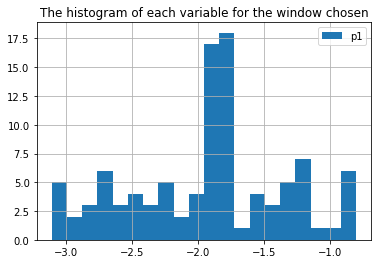

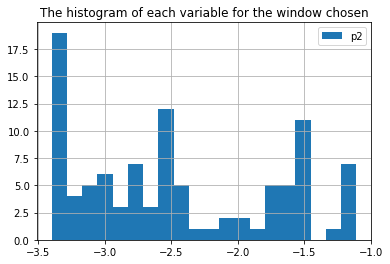

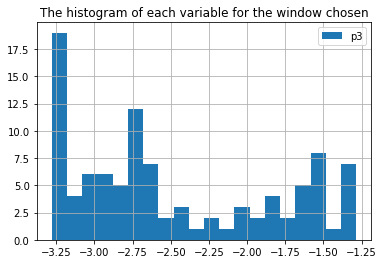

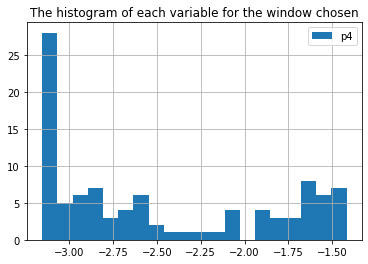

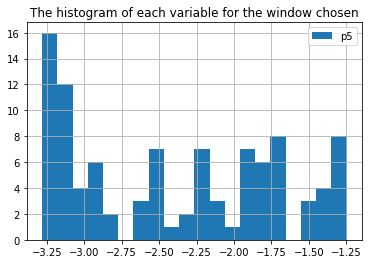

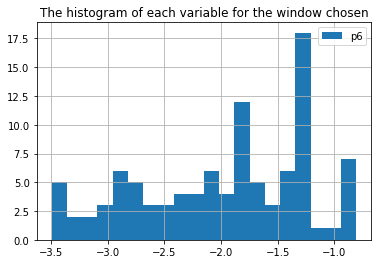

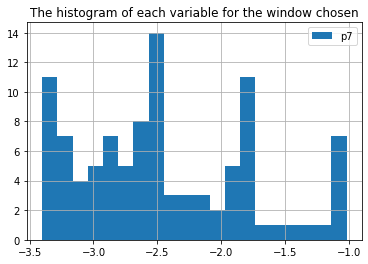

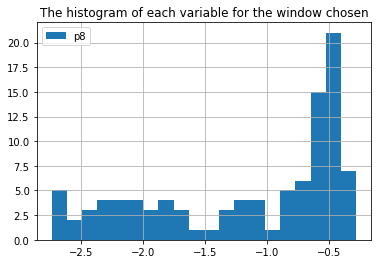

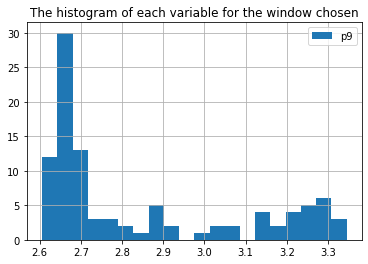

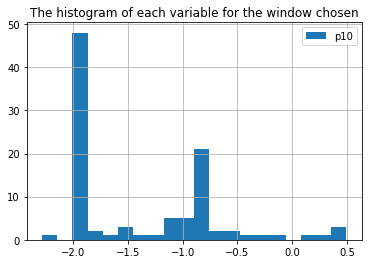

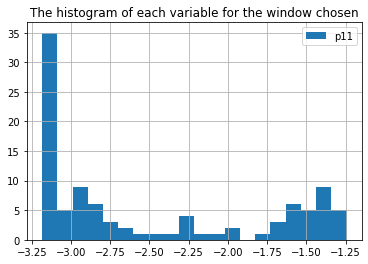

In [35]:
# Choose the window that you want to check here
window = "1_1_1"

print(f'The window selected is {window}.')
for i in np.arange(1,dataset.shape[1]):
    plt.figure()
    dataset[dataset.day_cycle_window == window].iloc[:,i].hist(bins = 20, label = dataset.columns[i])
    plt.title("The histogram of each variable for the window chosen")
    plt.legend()

## 5. <a id="sec5"></a>Conclusions

### A. <a id="sec5-1"></a>Anomalies detected
In this project, we begin with exploring the flight dataset detected for each "day_cycle_window" and found the type I anomalies, that is, those windows with less than 100 data points in each window. Then we temporarily removed these type I abnormal windows. 

For the remaining dataset, we calculated the median and MAD of each window in order to characterize the entire dataset. And draw their histograms to visualize the distribution of these two statistical variables, and found them roughly in compliance with the standard normal distribution at the level of the "window". 

Then we used two methods, PCA and Variance Threshold, to make feature selection, and by comparing their result scores, PCA has better performance, so we chose the two features selected by PCA for later analysis and visualization. 

After that, we used three different anomaly detection algorithms (Isolation Forest, Local Outlier Factor, One Class SVM) to detect the abnormal windows base on the datasets of these two statistical variables, the median and MAD, respectively, and got different detection results and visualized them. 

For the analysis of these results, if we intuitively consider that the points that are sparsely distributed and far from the center population are anomalies, then the One Class SVM algorithm shows a relatively good performance. However, since we don't know exactly the specific physical meaning of the 11 parameters in the dataset, we cannot subjectively determine which algorithm of the three is the best and which is not good. This requires further analysis and discussion with the expert and adopts them as needed.

### B. <a id="sec5-2"></a>Open questions

After the whole anomaly detection process, some questions remain open. We need to have aircraft system expert's feedback to confirm if the process suits the technical needs. Three core questions are listed as below:
+ Definition and percentage of anomalies: A precise definition of anomaly can help improve the process and integrate some necessary steps. Percentage is an important information to be added into the detection algorithm.
+ Distribution pattern of anomalies: A rough pattern of anomaly distribution can help to choose one algorithm among the proposed three algorithms.
+ Necessity for manual setting of threshold for each variable: Some preprocessing step may be added if we have a reasonable interval for each variable. 